# Inverse fit: recover G(t) step values from measured pdp

Use `permeation.inverse_fit` to fit step values of the incident flux G(t) to measured downstream pressure (pdp). **Zoom fit** (`fit_G_steps_zoom`) starts with one step and refines by doubling the number of steps each level; use `fit_G_steps` for a single-level fit with fixed step times.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import permeation as pm

# Optional: nicer defaults for notebooks
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.figsize"] = (6, 4)

## 1. Define base parameters and "true" G(t) steps

We fix physics (ks, kd, D) and step *start* times; the inverse fit finds the step *values*.

In [2]:
base_params = pm.Parameters()
base_params.ks = 3.3e19
base_params.kd = 1.2e-34
base_params.D = 1e-8

tstart = [0.0, 0.2, 0.4, 0.5]   # step start times (fraction of run)
true_vals = np.array([0.3, 0.7, 0.6, 0.0])  # true step values

# Forward simulate to get "true" pdp
t_true, pdp_true, _ = pm.simulate_from_step_vals(true_vals, tstart, base_params)

## 2. Synthetic measurements (noisy pdp on same time grid)

In [3]:
rng = np.random.default_rng(0)
t_meas = t_true.copy()
noise = 0.02 * np.max(pdp_true) * rng.normal(size=pdp_true.shape)
pdp_meas = pdp_true + noise

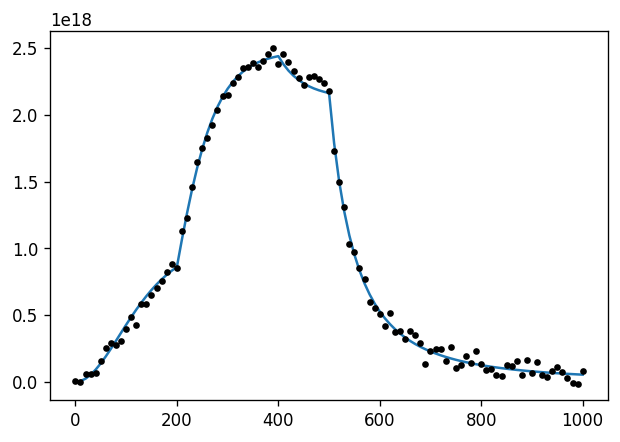

In [4]:
plt.plot(t_true,pdp_true,'-')
plt.plot(t_meas,pdp_meas,'k.')

## 3. Zoom fit: refine from one step to many

`fit_G_steps_zoom` starts with a single step over [0, 1], fits it, then doubles the number of steps each level via `refine_steps` and refits. No need to specify step times in advance.

In [21]:
n_levels = 6
zoom = pm.fit_G_steps_zoom(
    t_meas=t_meas,
    pdp_meas=pdp_meas,
    base_params=base_params,
    initial_guess=0.5,
    n_levels=n_levels,
    bounds=(0.0, 2.0),
    reg_l2=1e-6,
    reg_tv=1e-3,
    max_nfev=200,
    verbose=1,
)

# Final level result (for plotting)
fit = zoom["history"][-1]
print("Fitted step values (last level):", zoom["x_hat"])
print("Final cost:", fit["result"].cost)

`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 6.2156e+37, final cost 3.7092e+37, first-order optimality 3.21e+33.
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 3.7092e+37, final cost 6.9695e+36, first-order optimality 3.20e+33.
`ftol` termination condition is satisfied.
Function evaluations 17, initial cost 6.9695e+36, final cost 1.3210e+36, first-order optimality 5.98e+33.
`ftol` termination condition is satisfied.
Function evaluations 16, initial cost 1.3210e+36, final cost 3.5583e+35, first-order optimality 1.50e+33.
`ftol` termination condition is satisfied.
Function evaluations 14, initial cost 3.5583e+35, final cost 1.1089e+35, first-order optimality 4.87e+32.
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 19, initial cost 1.1089e+35, final cost 8.9624e+34, first-order optimality 2.10e+32.
Fitted step values (last level): [3.09087076e-01 3.35244348e-01 2.00029077e-01 2.9833953

## 4. Plot: measured vs fitted pdp, and recovered G(t)

Using the last zoom level’s fit.

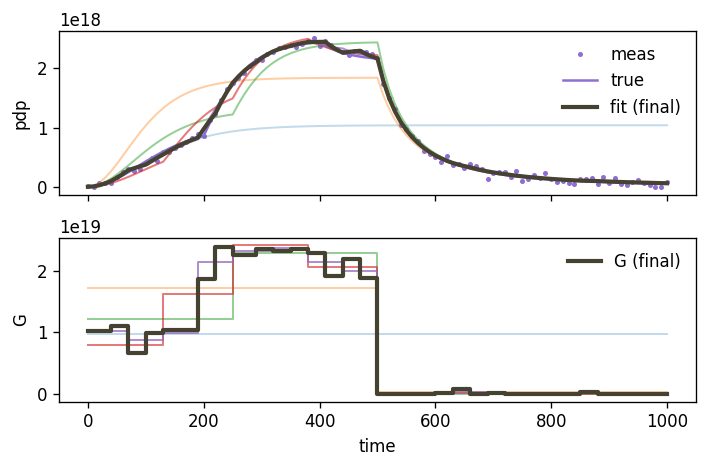

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t_meas, pdp_meas, "o",color="#8f6ed4", ms=2, label="meas")
ax1.plot(t_true,pdp_true,'-',color='#8f6ed4',label = "true")

# evolution across zoom levels
for k, h in enumerate(zoom["history"]):
    alpha = 0.15 + 0.7 * (k + 1) / len(zoom["history"])
    ax1.plot(h["t_model"], h["pdp_hat"], "-", lw=1.2, alpha=alpha)
    ax2.step(h["t_model"], h["G_hat"], where="post", lw=1.2, alpha=alpha)

# final fit highlight
ax1.plot(fit["t_model"], fit["pdp_hat"],
         "-", lw=2.5, color="#454231", label="fit (final)")
ax2.step(fit["t_model"], fit["G_hat"],
        where="post", lw=2.5, color="#454231", label="G (final)")

ax1.set_ylabel("pdp")
ax1.legend(frameon=False)

ax2.set_ylabel("G")
ax2.set_xlabel("time")
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()